In [1]:
import numpy as np # linear algebra
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm

from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler, ConcatDataset
from torch import nn, optim
import torch 
import copy
from sklearn.model_selection import train_test_split

from torchvision import transforms, datasets
import timm 
import timm.optim
from timm.data.transforms_factory import create_transform
from torch.optim import lr_scheduler
import os


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_hands = mp.solutions.hands

def mediapipeimg(image):

  with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    results = hands.process(image)
    # print('Handedness:', results.multi_handedness)



    image_height, image_width, _ = image.shape
    annotated_image = image.copy()

    landmark_tangan=[]
    for hand_landmarks in results.multi_hand_landmarks:
     
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
    
    for hand_world_landmarks in results.multi_hand_world_landmarks:
      fitur = []
      data = []
      for h in range(0,20):
          x = hand_world_landmarks.landmark[h].x
          y = hand_world_landmarks.landmark[h].y
          z = hand_world_landmarks.landmark[h].z
          fitur.append(x)
          fitur.append(y)
          fitur.append(z)
      data.extend(fitur)
      x = 0
      y = 0
      z = 0



    return results, annotated_image, data

In [3]:
import cv2
import math
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import torchvision.transforms as T


base_options = python.BaseOptions(model_asset_path='../gesture_recognizer.task')
options = vision.GestureRecognizerOptions(base_options=base_options)
recognizer = vision.GestureRecognizer.create_from_options(options)



def handGesture(img):
    landmarks = []
    errr = None
    # image = mp.Image.create_from_file(img)
    imgPil = T.ToPILImage()(img)
        
    medPil = mp.Image(
            image_format=mp.ImageFormat.SRGB, data=np.asarray(imgPil))
    recognition_result = recognizer.recognize(medPil)
    hand_landmarks = recognition_result.hand_landmarks
    if(len(hand_landmarks) != 0):
        for a in range(0,len(hand_landmarks[0])):
            x = hand_landmarks[0][a].x
            y = hand_landmarks[0][a].y
            z = hand_landmarks[0][a].z
            landmarks.append(x)
            landmarks.append(y)
            landmarks.append(z)
        errr = None
        return landmarks, errr
    else:
        errr = 1
        return landmarks, errr



In [4]:
# create dataset
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.datasets as datasets


class dawtaset(Dataset):
    def __init__(self, image_path, transform=None, featureExtraction=None):
        super(dawtaset, self).__init__()
        self.image_folder = datasets.ImageFolder(image_path)
        self.transform = transform
        self.featureExtraction = featureExtraction
    def __len__(self):
        return len(self.image_folder)
    
    def __getitem__(self, idx):
        image, label = self.image_folder[idx]
        path = self.image_folder.imgs[idx][0]
        data = self.image_folder
        # Apply transformations (if needed)
        if self.transform:
            image = self.transform(image)
        
        if self.featureExtraction:
            feature, err = self.featureExtraction(image)
            if (err != None):
                return self.__getitem__(idx + 1)
            else:
                custom_features = feature
        
        
        hasil = {
            'image': image,
            'labels': label,
            'id_class': idx,
            'custom_features': custom_features,
            'data': data
        }
        
        return hasil

In [5]:
from torch.utils.data import DataLoader, TensorDataset

train_transform = transforms.Compose([
     transforms.RandomRotation(degrees=(30, 70)),
    transforms.Resize((100, 100)),
    # transforms.Grayscale(1),
    # transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomVerticalFlip(p=0.5),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
   
    transforms.ToTensor(),
   
])
dataset = dawtaset(image_path="../asl_dataset", transform=train_transform, featureExtraction=handGesture)

print(type(dataset))

<class '__main__.dawtaset'>


C:\Users\intel\AppData\Local\Temp\ipykernel_32988\2945756074.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2318.)
  ax[0,i].imshow(hasil["image"].T, cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)


Text(0, 0.5, 'Augmented Images')

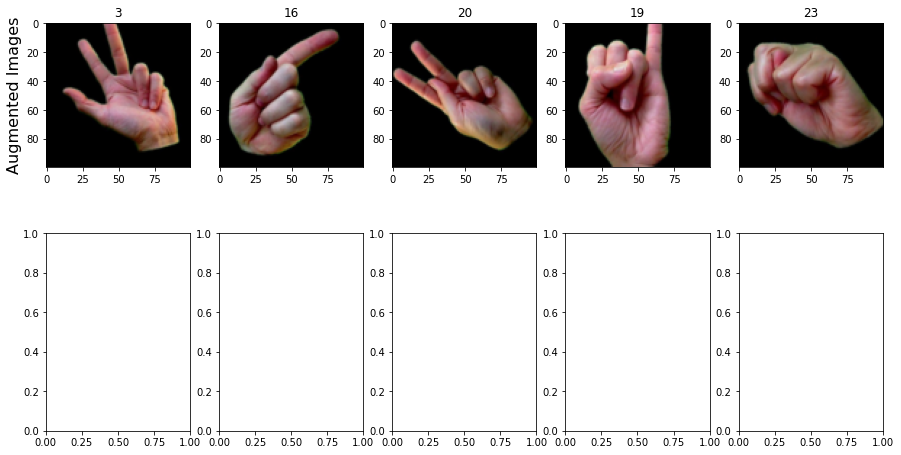

In [6]:
#Visualizing some examples in the training dataset X
from random import randrange
fig, ax = plt.subplots(nrows = 2, ncols = 5,  figsize = (15,8))
for i in range(5):
    a = randrange(2000)
    hasil = dataset.__getitem__(a)
    
    ax[0,i].imshow(hasil["image"].T, cmap="magma") # Squeeze removes length (1,28,28) -> (28,28)
    ax[0,i].set_title(int(hasil["labels"]))
    

ax[0,0].set_ylabel('Augmented Images',fontdict= {'fontsize':16})

In [7]:
hasil = dataset.__getitem__(1)
idx_to_class = {v: k for k, v in hasil["data"].class_to_idx.items()}

def get_class_distribution(dataset):
    count_dict = {k:0 for k,v in hasil["data"].class_to_idx.items()} # initialise dictionary
    
    for input, label in hasil["data"]:
        label = idx_to_class[label]
        count_dict[label] += 1
            
    return count_dict

print("Distribution of classes: ", get_class_distribution(hasil))

get_class_distribution(hasil)

Distribution of classes:  {'0': 70, '1': 70, '2': 70, '3': 70, '4': 70, '5': 70, '6': 70, '7': 70, '8': 70, '9': 70, 'a': 70, 'b': 70, 'c': 70, 'd': 70, 'e': 70, 'f': 70, 'g': 70, 'h': 70, 'i': 70, 'j': 70, 'k': 70, 'l': 70, 'm': 70, 'n': 70, 'o': 70, 'p': 70, 'q': 70, 'r': 70, 's': 70, 't': 65, 'u': 70, 'v': 70, 'w': 70, 'x': 70, 'y': 70, 'z': 70}


{'0': 70,
 '1': 70,
 '2': 70,
 '3': 70,
 '4': 70,
 '5': 70,
 '6': 70,
 '7': 70,
 '8': 70,
 '9': 70,
 'a': 70,
 'b': 70,
 'c': 70,
 'd': 70,
 'e': 70,
 'f': 70,
 'g': 70,
 'h': 70,
 'i': 70,
 'j': 70,
 'k': 70,
 'l': 70,
 'm': 70,
 'n': 70,
 'o': 70,
 'p': 70,
 'q': 70,
 'r': 70,
 's': 70,
 't': 65,
 'u': 70,
 'v': 70,
 'w': 70,
 'x': 70,
 'y': 70,
 'z': 70}

Text(0.5, 1.0, 'Class Distribution of the ASL static Dataset')

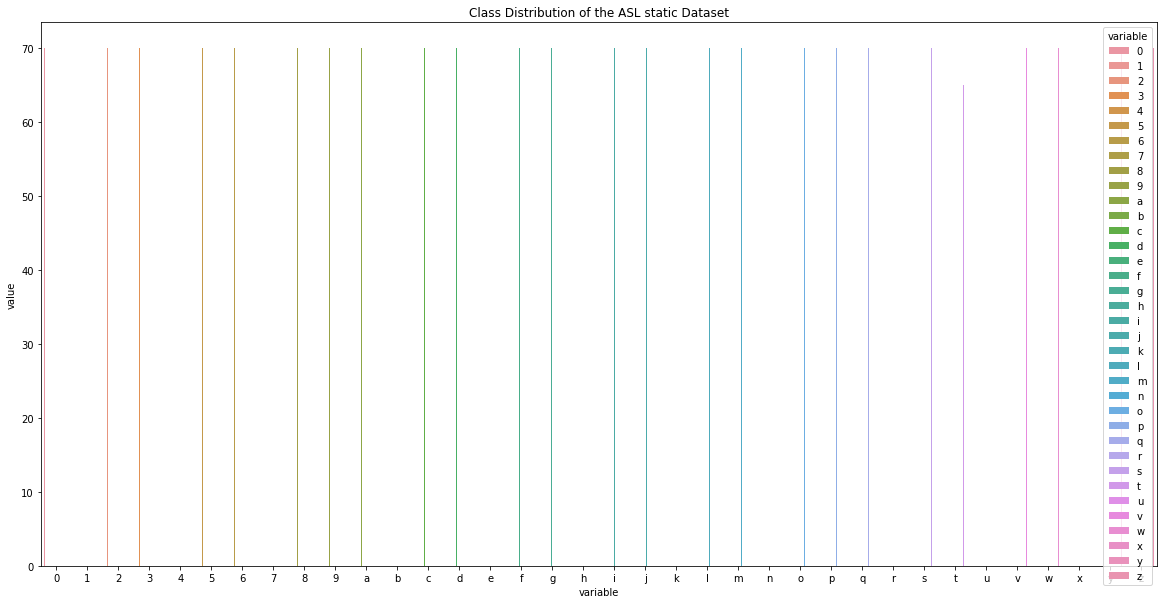

In [8]:

plt.figure(figsize=(20, 10))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(dataset)]).melt(), 
            x = "variable", y="value", hue="variable").set_title('Class Distribution of the ASL static Dataset')

In [9]:
train_dataset, val_dataset, test_dataset = random_split(dataset, [1500, 750, 265])

train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size=1, drop_last=True)
val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=1)

print("Length of the train_loader:", len(train_loader))
print("Length of the val_loader:", len(val_loader))
print("Length of the test_loader:", len(test_loader))

Length of the train_loader: 1500
Length of the val_loader: 750
Length of the test_loader: 265


Text(0.5, 1.0, 'Test Set')

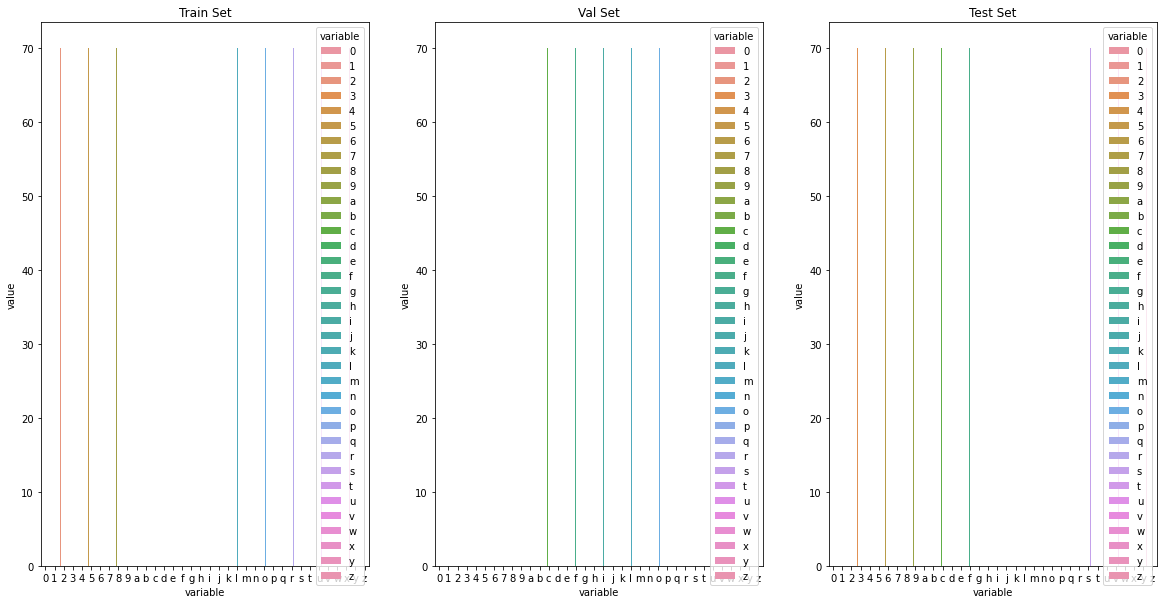

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,10))
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(train_loader.dataset)]).melt(),
            x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Train Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(val_loader.dataset)]).melt(), 
            x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Val Set')
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(test_loader.dataset)]).melt(),
            x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Test Set')

In [11]:
import torch.nn.functional as F

class MyModelDefault(nn.Module):
    def __init__(self):
        super(MyModelDefault, self).__init__()
        self.cnn = timm.create_model('mobilenetv3_small_100', pretrained=True)
        self.cnn.fc = nn.Linear(
            self.cnn.classifier.in_features, self.cnn.classifier.out_features
        )
        self.fc1 = nn.Linear(self.cnn.fc.out_features, 100)
        self.fc2 = nn.Linear(100, 36)
    def forward(self, image):
        x1 = self.cnn(image)
        
        # x = torch.cat((x1, x2), dim=1)
        
        x = F.relu(self.fc1(x1))
        x = self.fc2(x)
        return x

model = MyModelDefault()
model

MyModelDefault(
  (cnn): MobileNetV3(
    (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): Hardswish()
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (bn1): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): ReLU(inplace=True)
            (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (gate): Hardsigmoid()
          )
          (conv_pw): Conv2d(16, 16, kernel_size=(1, 1),

In [12]:
from torch import tensor
import torchvision.transforms as T
from PIL import Image as im 
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)

model = model.to(device=device)
trainingEpoch_loss = []
validationEpoch_loss = []
validation_acc = []

for epoch in range(100):
    train_loss = 0.0
    for i, data in enumerate(train_loader.dataset, 0):
        image = torch.as_tensor(data["image"]).unsqueeze(0).to(device=device)
        labels = torch.as_tensor(data["labels"]).unsqueeze(0).to(device=device)
                      
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        # print(torch.as_tensor(data["image"].unsqueeze(0)))
        # print(torch.as_tensor(data["custom_features"]).unsqueeze(0))
        # print(torch.as_tensor(data["labels"]).unsqueeze(0))
        loss.backward()
        optimizer.step()
                # writer.add_scalar("Loss/train", loss, epoch)
        train_loss += loss.item()
        
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for i, data in enumerate(val_loader.dataset, 0): 
            image = torch.as_tensor(data["image"]).unsqueeze(0).to(device=device)
            labels = torch.as_tensor(data["labels"]).unsqueeze(0).to(device=device)
            # Forward Pass
            target = model(image)
            # Find the Loss
            loss = criterion(target, labels)
        
            _, predicted = torch.max(target, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)
            # Calculate Loss
            valid_loss += loss.item()
        validation_accuracy = total_correct / total_samples
        # print(f"Epoch [{epoch+1}/{epoch}] Validation Accuracy: {validation_accuracy:.4f}")
 
    print(f'Epoch {epoch+1} \t\t Validation Accuracy: {validation_accuracy:.4f} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {valid_loss / len(val_loader)}')
    trainingEpoch_loss.append(train_loss)
    validationEpoch_loss.append(valid_loss)
    validation_acc.append(validation_accuracy)
    
                   
            
    

Epoch 1 		 Validation Accuracy: 0.0907 		 Training Loss: 3.2213567612767218 		 Validation Loss: 3.3240212489763894
Epoch 2 		 Validation Accuracy: 0.0493 		 Training Loss: 3.5478724536101023 		 Validation Loss: 3.372282195409139
Epoch 3 		 Validation Accuracy: 0.0987 		 Training Loss: 3.0849039258559543 		 Validation Loss: 2.7769131809075676
Epoch 4 		 Validation Accuracy: 0.2280 		 Training Loss: 2.5941977499028046 		 Validation Loss: 2.3734976187547048
Epoch 5 		 Validation Accuracy: 0.3520 		 Training Loss: 2.113161859507362 		 Validation Loss: 1.7442481040557225
Epoch 6 		 Validation Accuracy: 0.5493 		 Training Loss: 2.4327585296500476 		 Validation Loss: 1.2384025898581992
Epoch 7 		 Validation Accuracy: 0.6533 		 Training Loss: 1.157073902908053 		 Validation Loss: 0.985130715670685
Epoch 8 		 Validation Accuracy: 0.6440 		 Training Loss: 0.9010190274714454 		 Validation Loss: 0.8866640743115761
Epoch 9 		 Validation Accuracy: 0.7213 		 Training Loss: 0.7616173114144524 		 Valid

<function matplotlib.pyplot.show(close=None, block=None)>

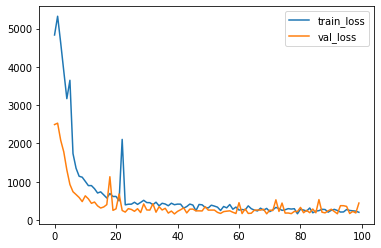

In [13]:
from matplotlib import pyplot as plt
plt.plot(trainingEpoch_loss, label='train_loss')
plt.plot(validationEpoch_loss,label='val_loss')
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

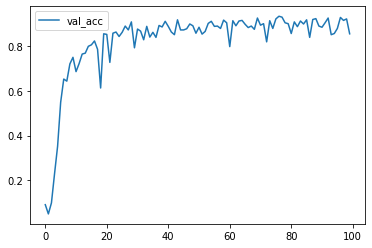

In [14]:
from matplotlib import pyplot as plt
plt.plot(validation_acc, label='val_acc')
plt.legend()
plt.show